In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings; warnings.filterwarnings("ignore")
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
import seaborn as sns
import autograd.numpy as np
#import numpy as np
import pandas as pd
import time

In [2]:
tumor_type = "ACC"

In [3]:
TCGA_data      =  './data/Simulated_TCGA_data.tsv'
TCGA_metadata  =  './data/Simulated_TCGA_metadata.tsv'
gene_list      =  './data/Genes_of_Interest.txt'

In [4]:
expression_data  =  pd.read_csv(TCGA_data, sep='\t',index_col=False)
clinical_data    =  pd.read_csv(TCGA_metadata, sep='\t',index_col=False)

In [5]:
alldata = pd.merge(expression_data, clinical_data,on='SampleID', how='left')
df  = alldata.loc[alldata['CancerType'] == tumor_type]

In [6]:
genes = open(gene_list).read().split()
#print("\nSearching", len(genes), "Genes of Interest:\n")
# genes = ['Gene_A', 'Gene_B', 'Gene_C', 'Gene_D', 'Gene_E', 'Gene_F', 'Gene_G']
# print(genes)
# alldata0 = alldata[[*genes]]
# alldata0.head(3)

In [7]:
#arr = alldata.CancerType.astype('str').unique()
#cancerlist = arr.tolist()
cancerlist = alldata.CancerType.astype('str').unique().tolist()
print(cancerlist)

['ACC', 'BLCA', 'LGG', 'CESC']


In [8]:
print(alldata.shape, "- - - >>>", df.shape)

(2000, 11) - - - >>> (500, 11)


In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = df.select_dtypes(include=numerics)
#new_df.head()

In [10]:
kmf = KaplanMeierFitter()
cph = CoxPHFitter()

In [11]:
#df = alldata.drop(['SampleID', 'CancerType'], axis = 1)
df = alldata.drop(['CancerType'], axis = 1)
print(df.head(),"\n")

      SampleID  Gene_A  Gene_B  Gene_C  Gene_D  Gene_E  Gene_F  Gene_G    T  E
0  Sample_0001  6.6673  5.7691  9.1580  7.0988  6.7225  9.4109  4.5289  289  1
1  Sample_0002  3.8712  4.7949  5.5913  7.6976  9.7312  2.2967  5.2969  245  1
2  Sample_0003  5.3227  8.8052  8.5147  8.8254  9.7246  9.5673  6.7407  532  1
3  Sample_0004  6.6650  3.1806  8.1542  3.1974  1.5425  8.9108  4.9463  441  1
4  Sample_0005  6.0273  2.0288  3.0588  3.2669  3.4156  7.2928  8.5980  894  1 



In [12]:
alldata0 = alldata[[*genes]]
alldata0.head(3)

,Gene_A,Gene_B,Gene_C,Gene_D,Gene_E,Gene_F,Gene_G
0,6.6673,5.7691,9.1580,7.0988,6.7225,9.4109,4.5289
1,3.8712,4.7949,5.5913,7.6976,9.7312,2.2967,5.2969
2,5.3227,8.8052,8.5147,8.8254,9.7246,9.5673,6.7407


In [13]:
df0 = alldata0.iloc[:, 0:10]; df0.columns.tolist()

['Gene_A', 'Gene_B', 'Gene_C', 'Gene_D', 'Gene_E', 'Gene_F', 'Gene_G']

In [14]:
range(len(alldata0.columns))

range(0, 7)

In [15]:
arr = alldata.CancerType.astype('str').unique(); cancerlist = arr.tolist()

#cancerlist = ['ACC']   
print(cancerlist)

['ACC', 'BLCA', 'LGG', 'CESC']


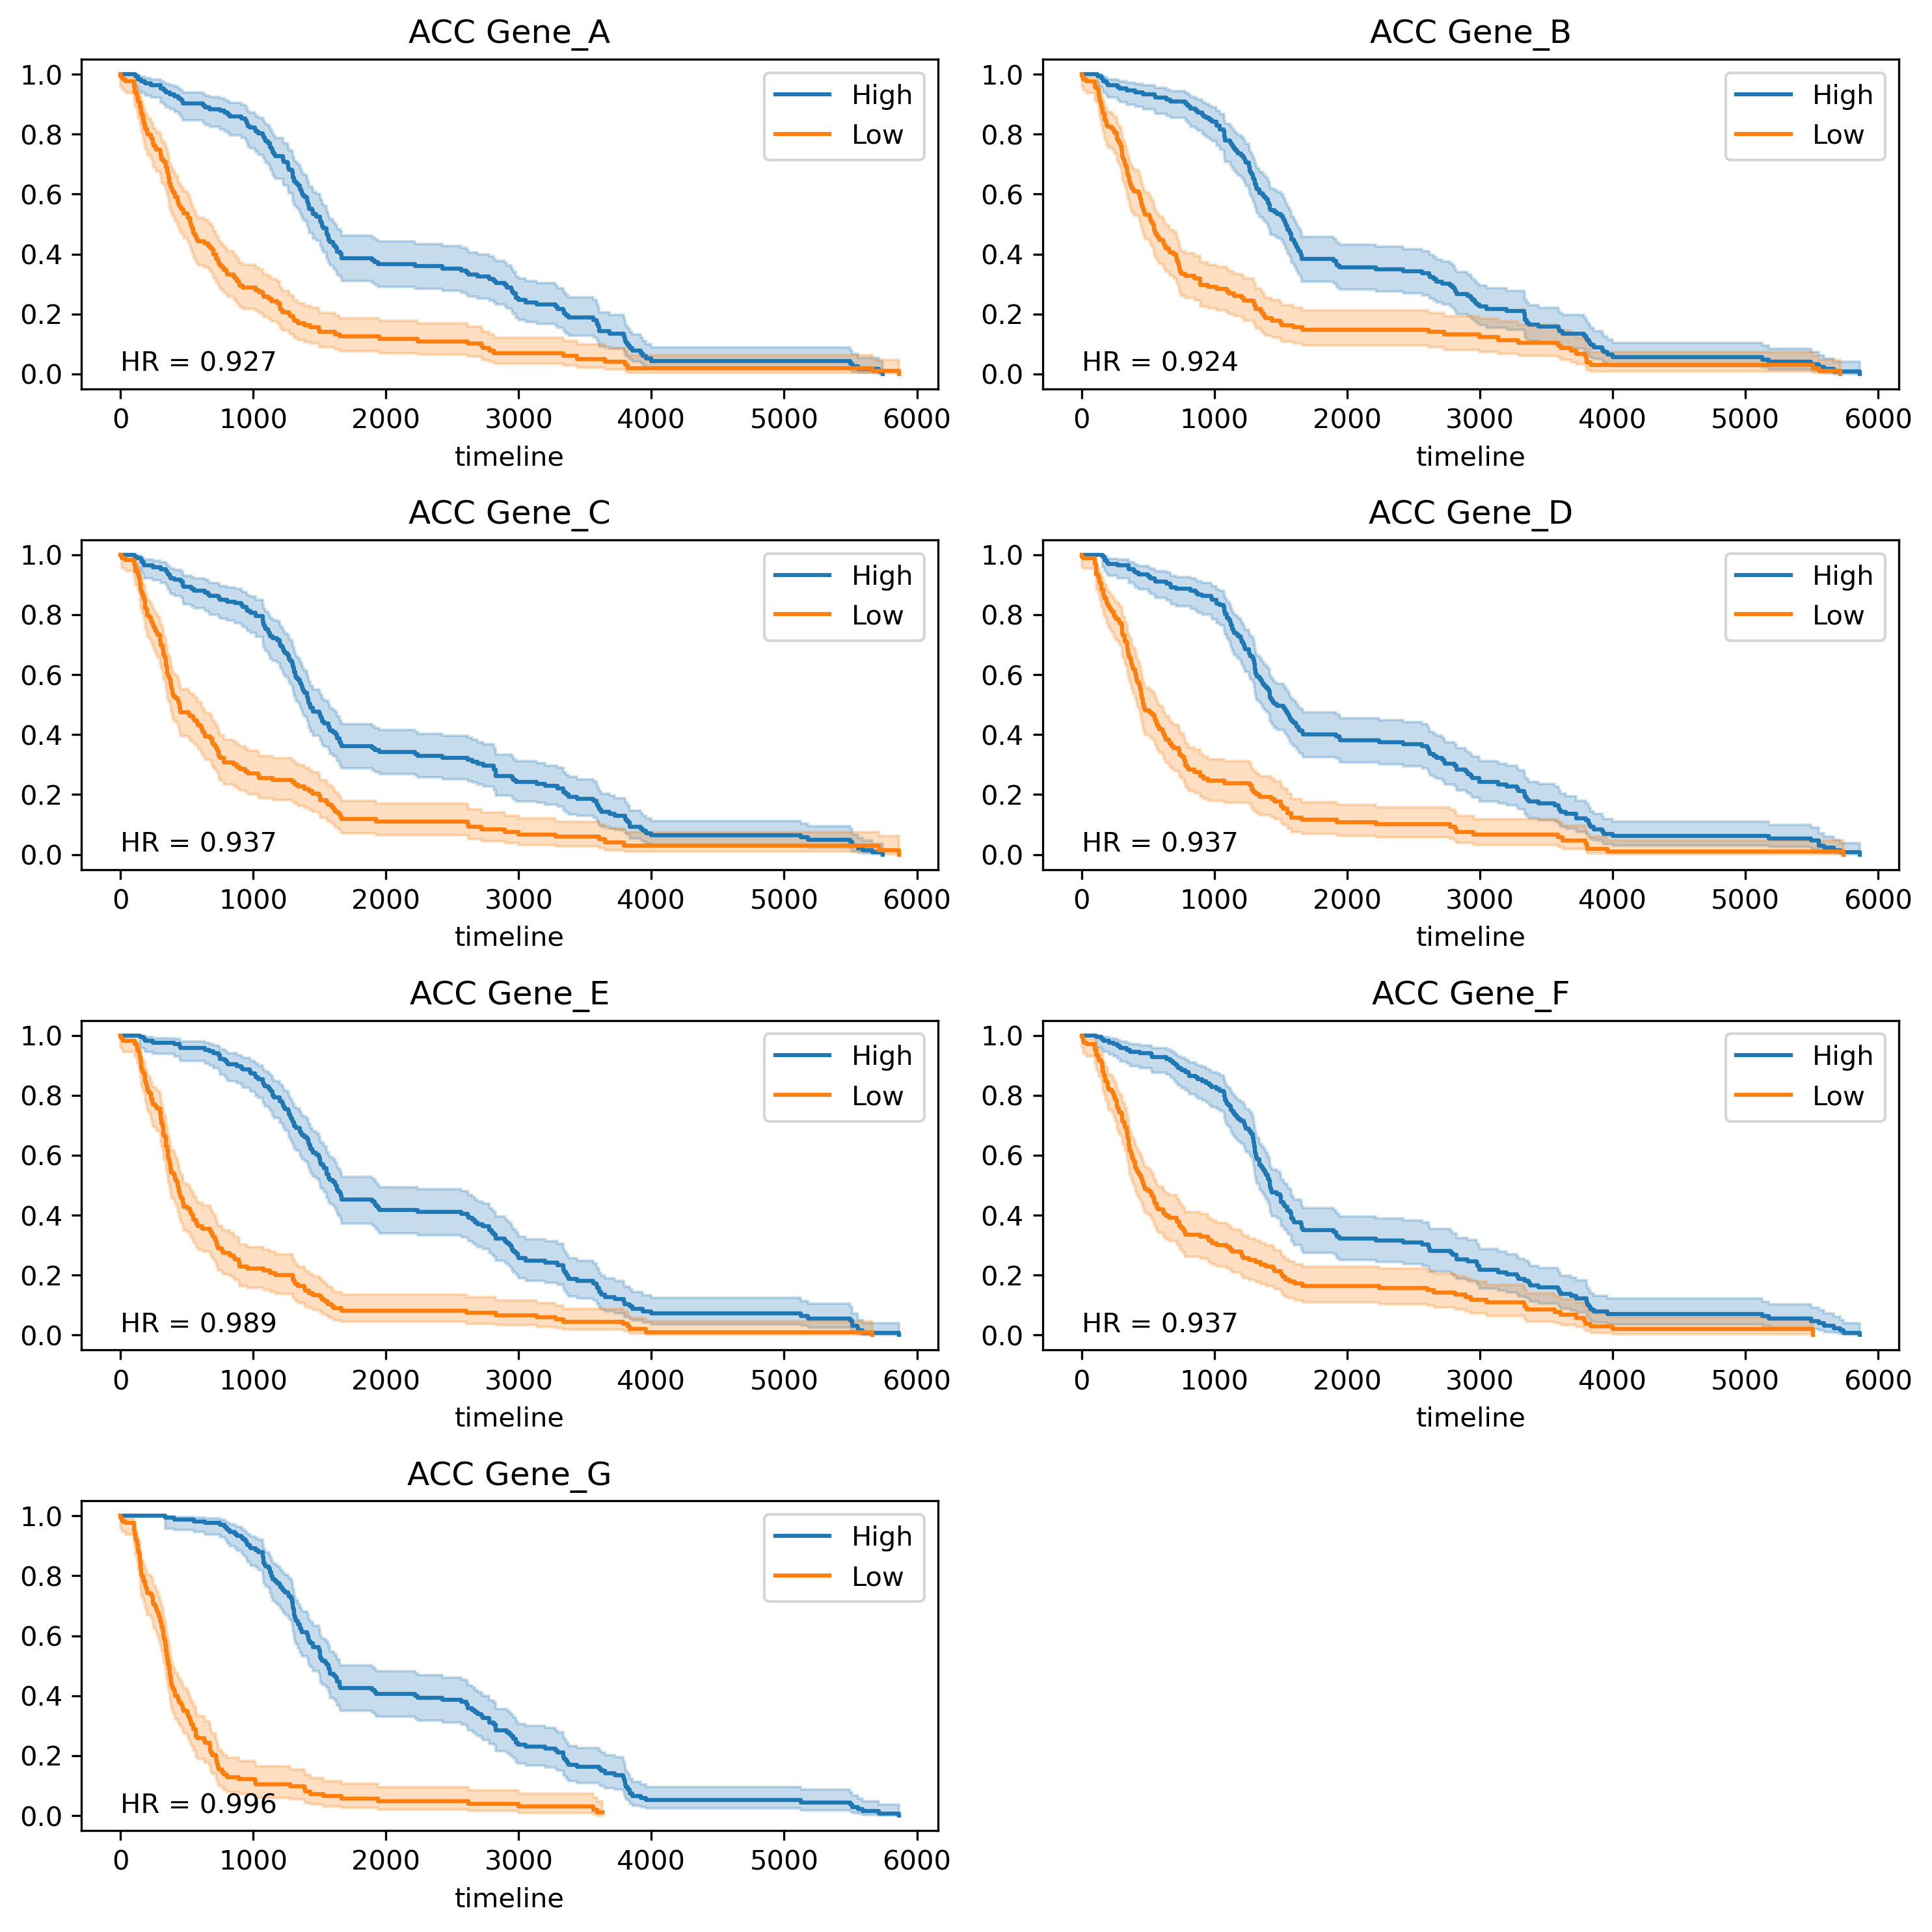

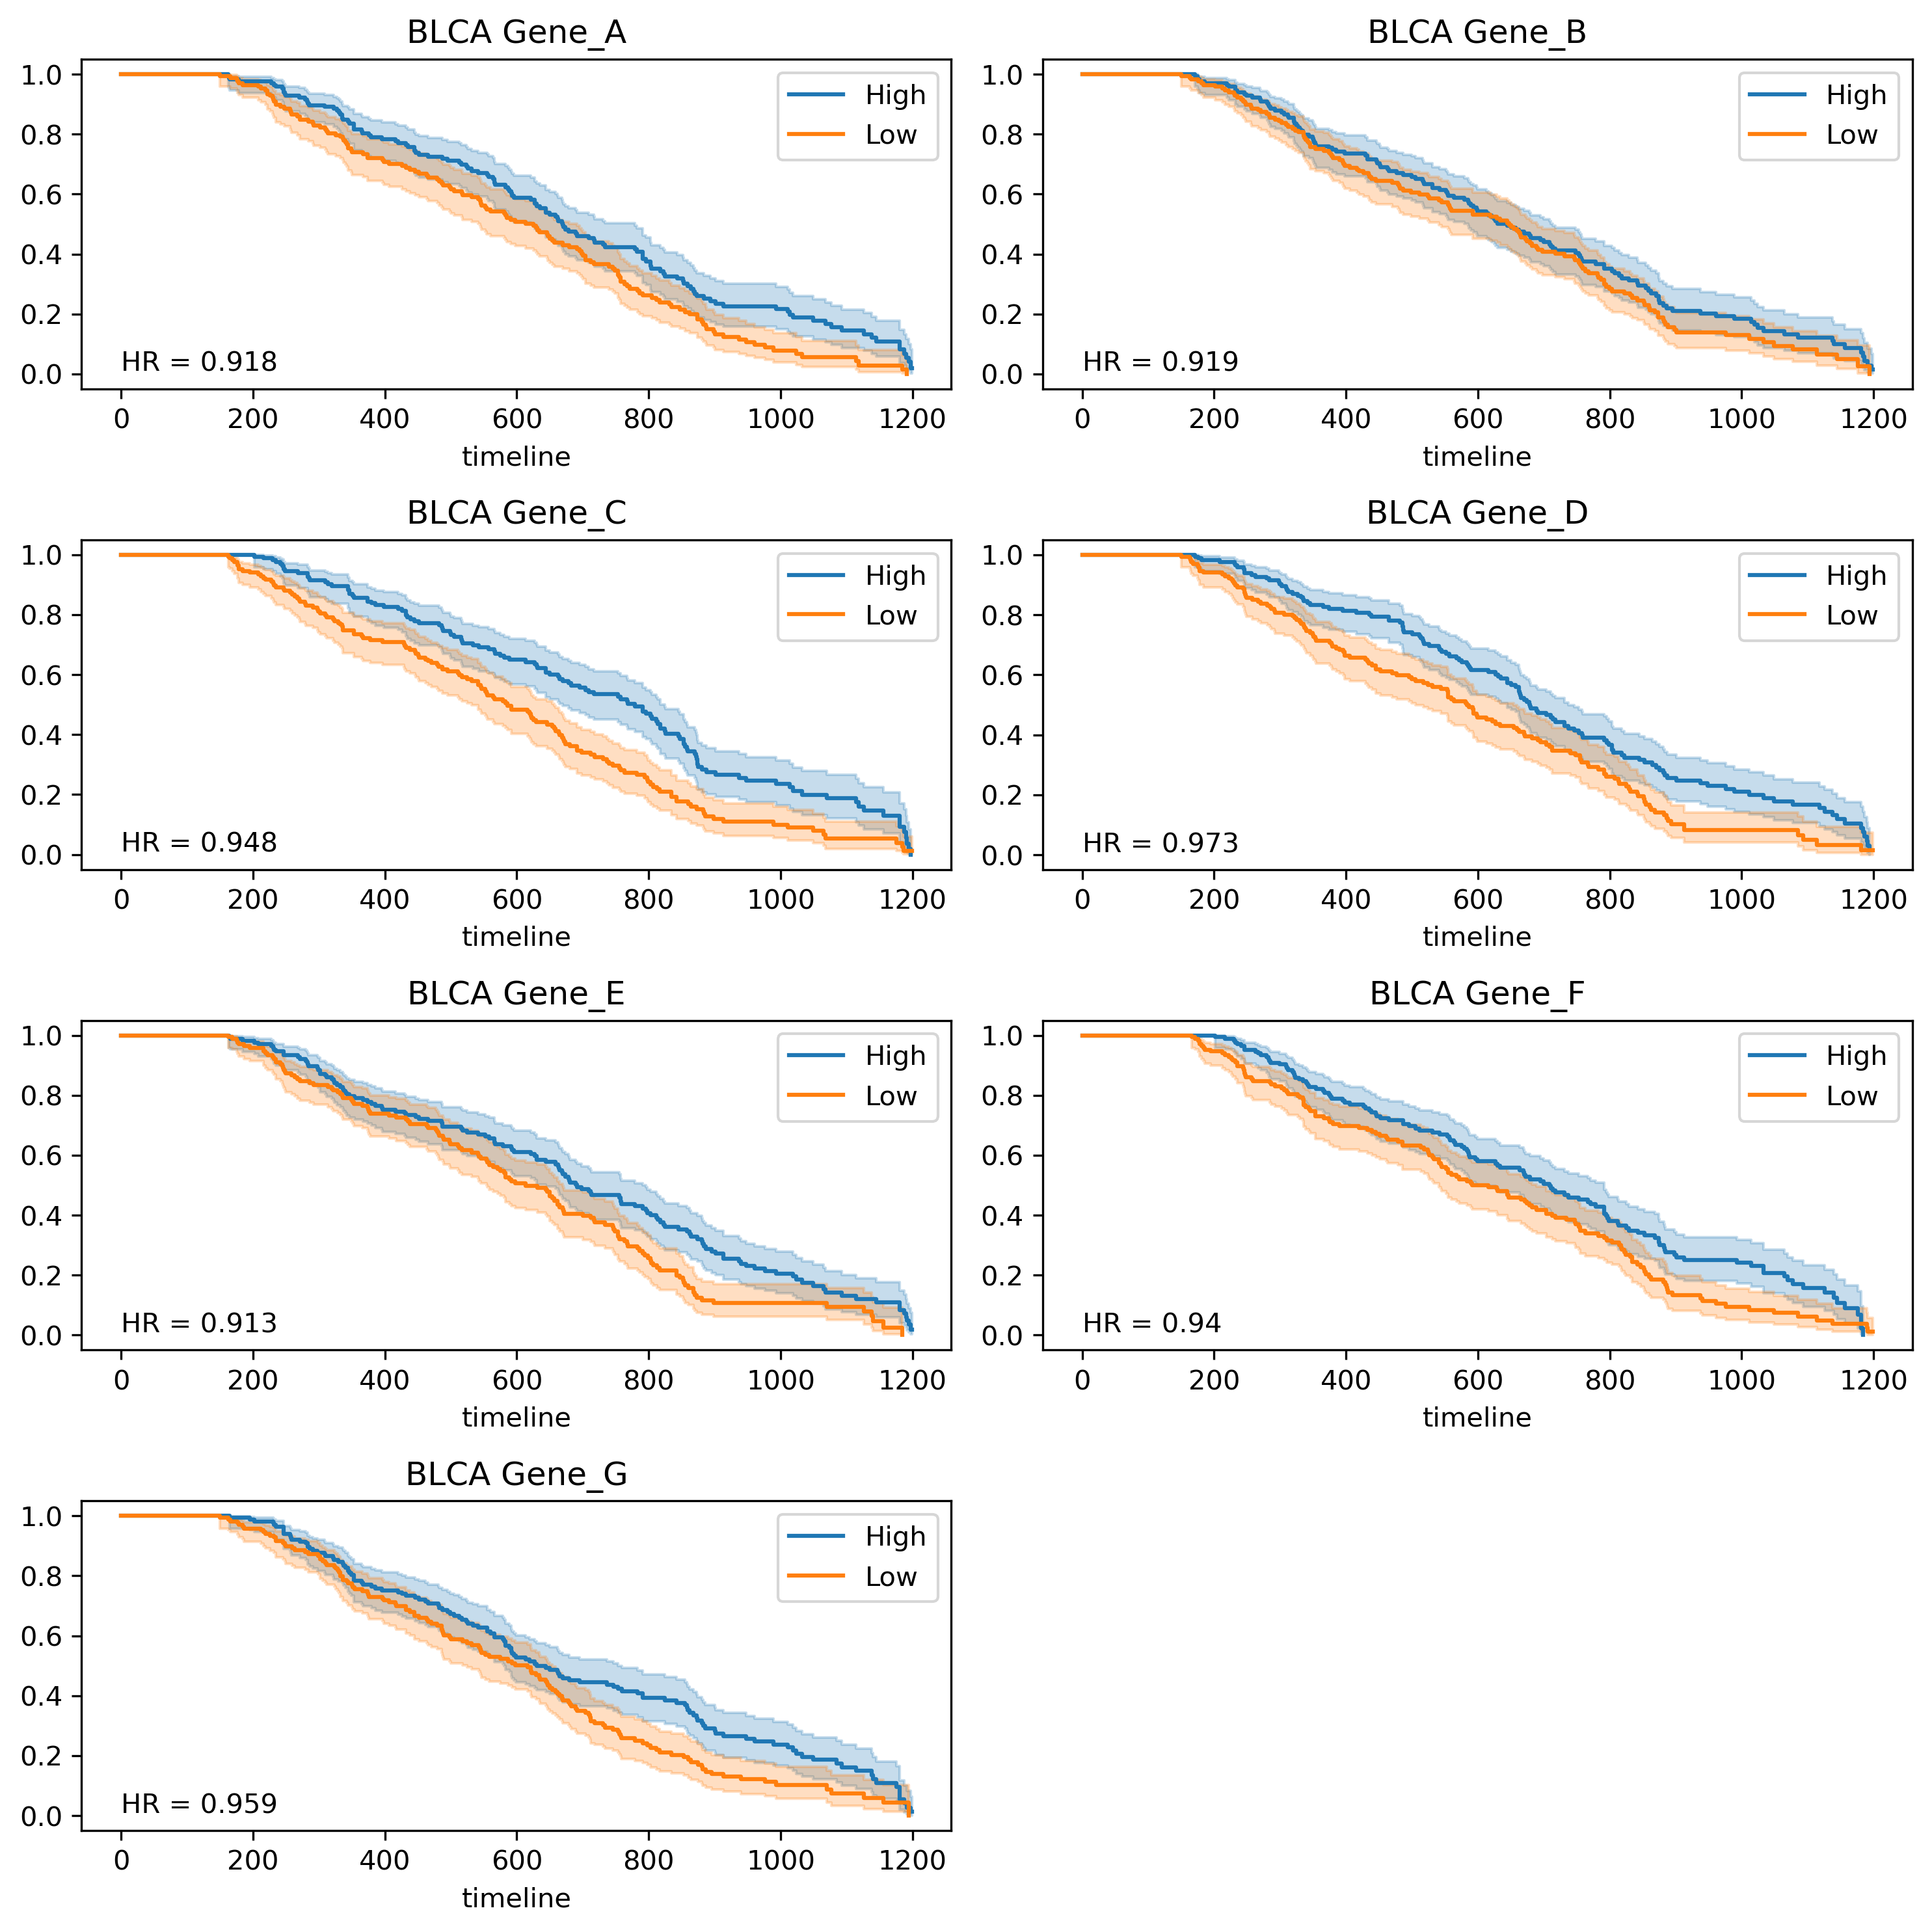

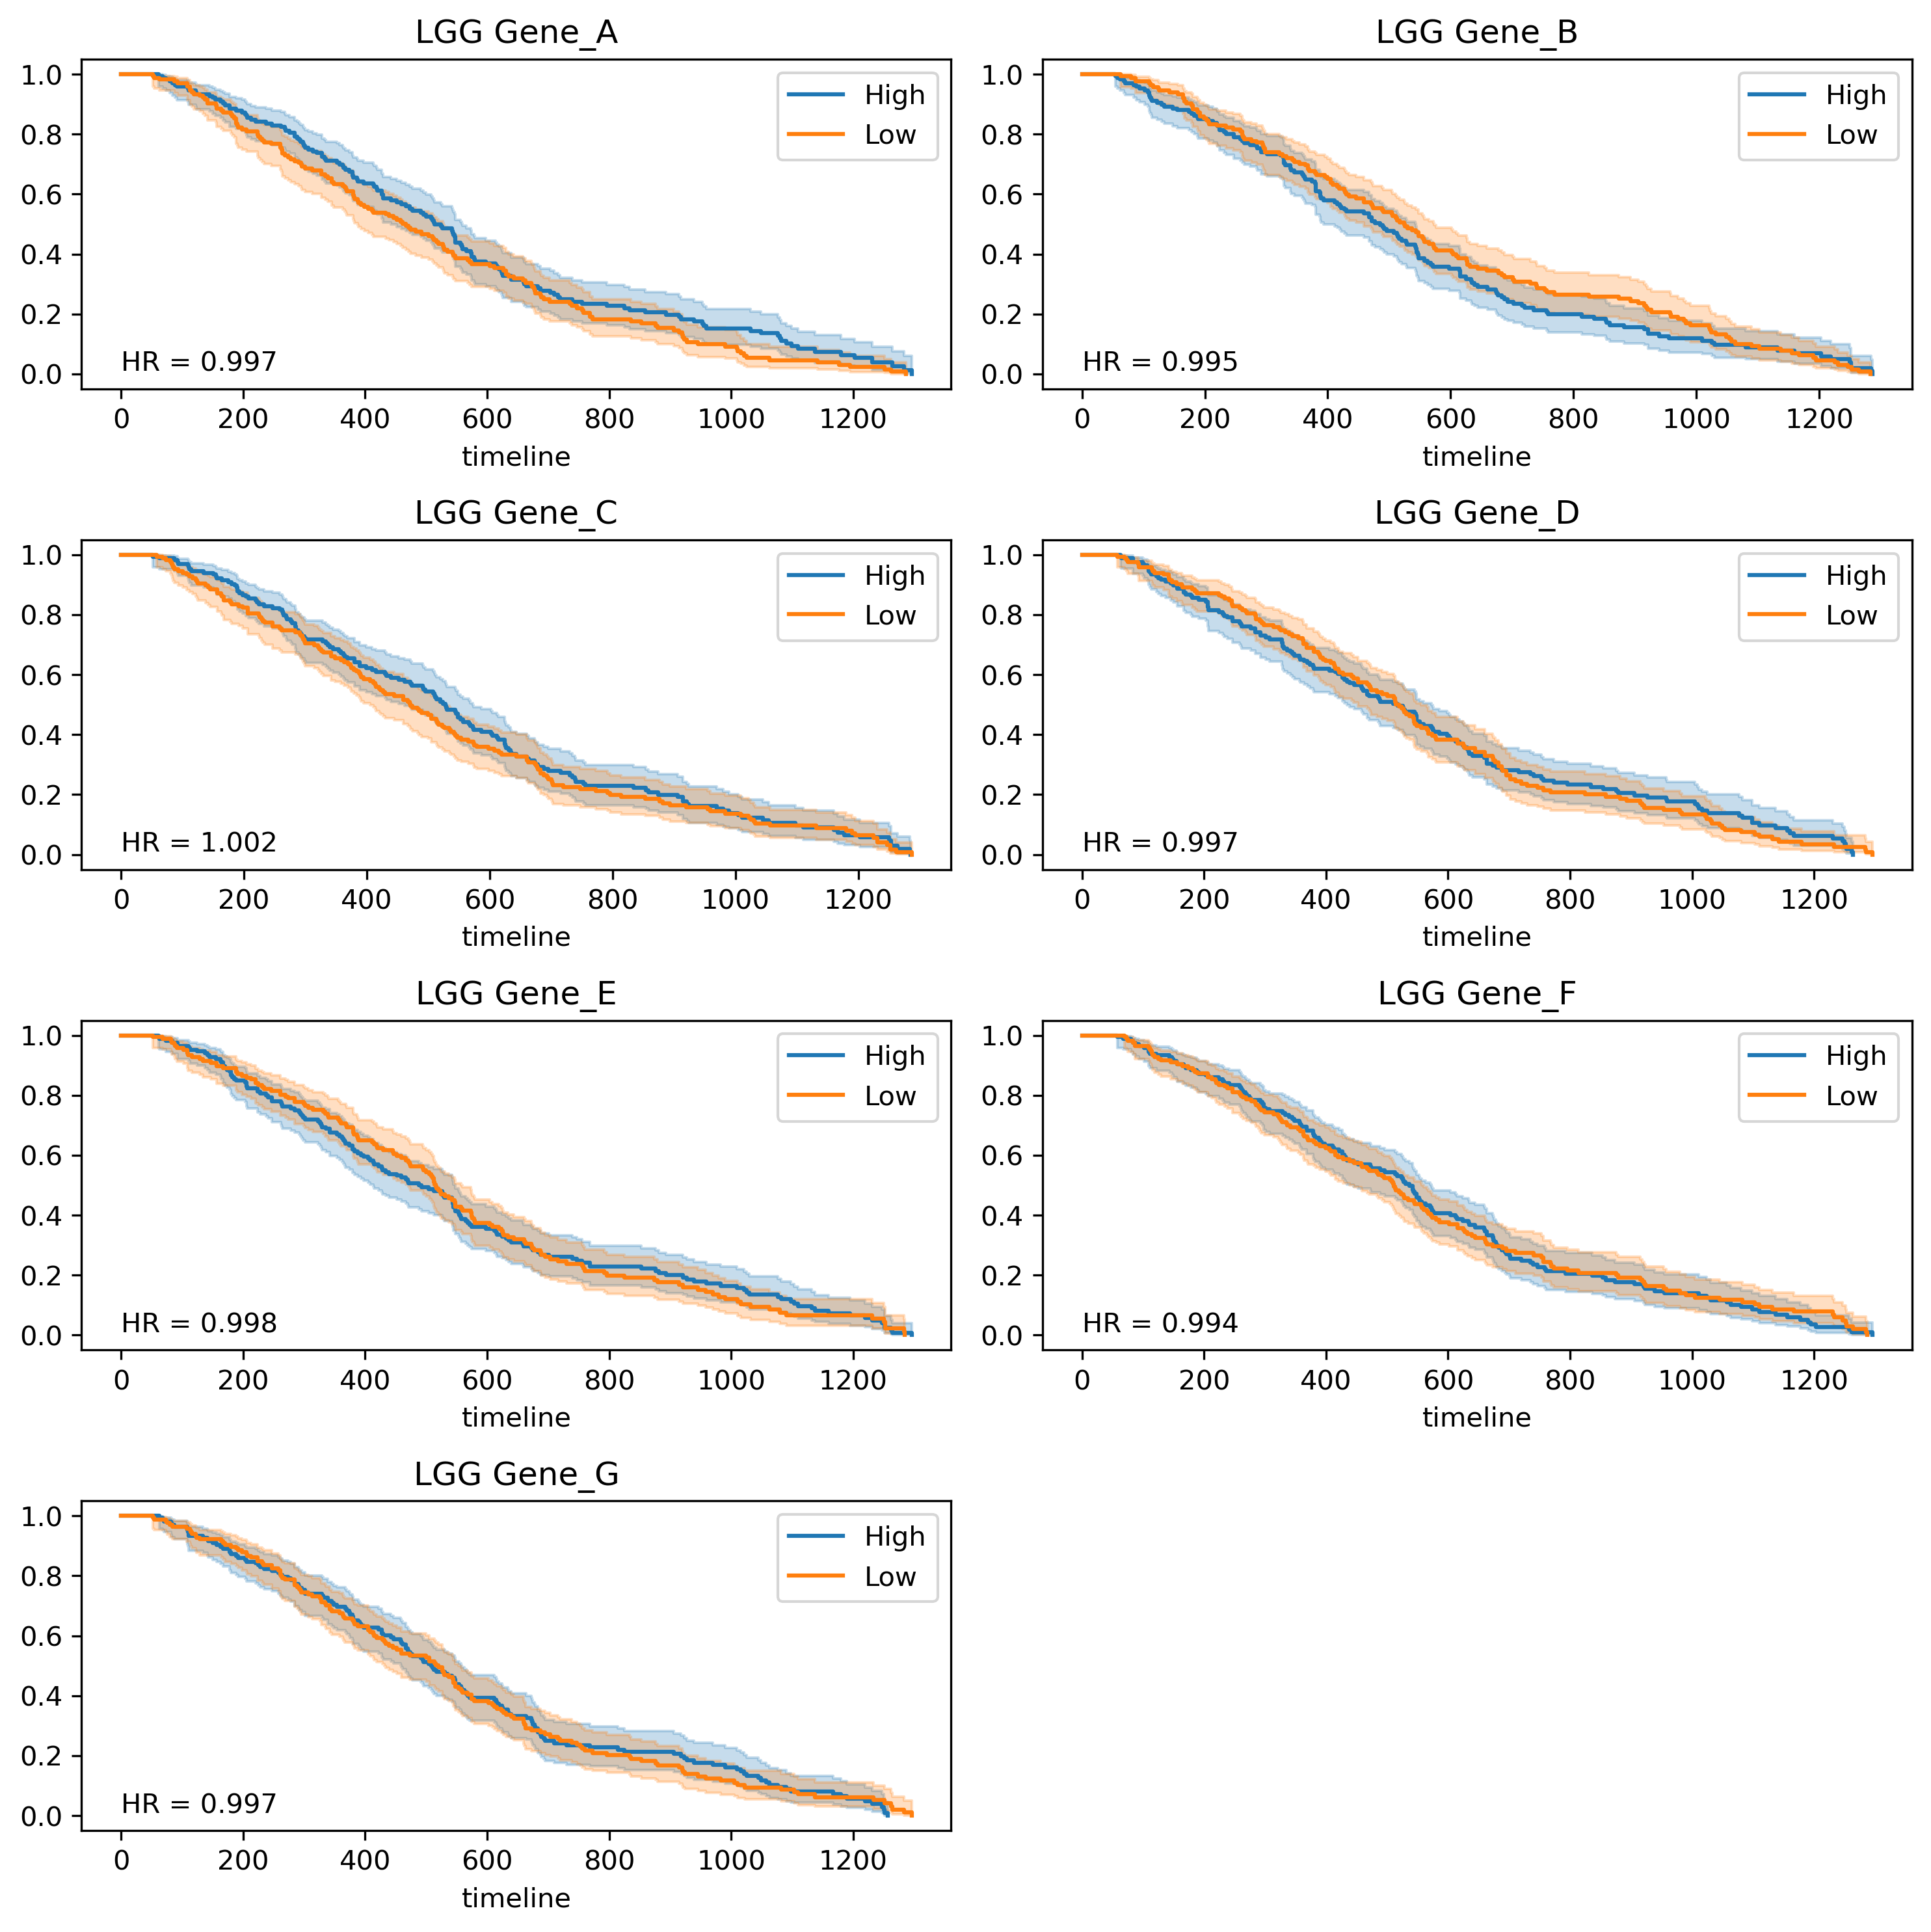

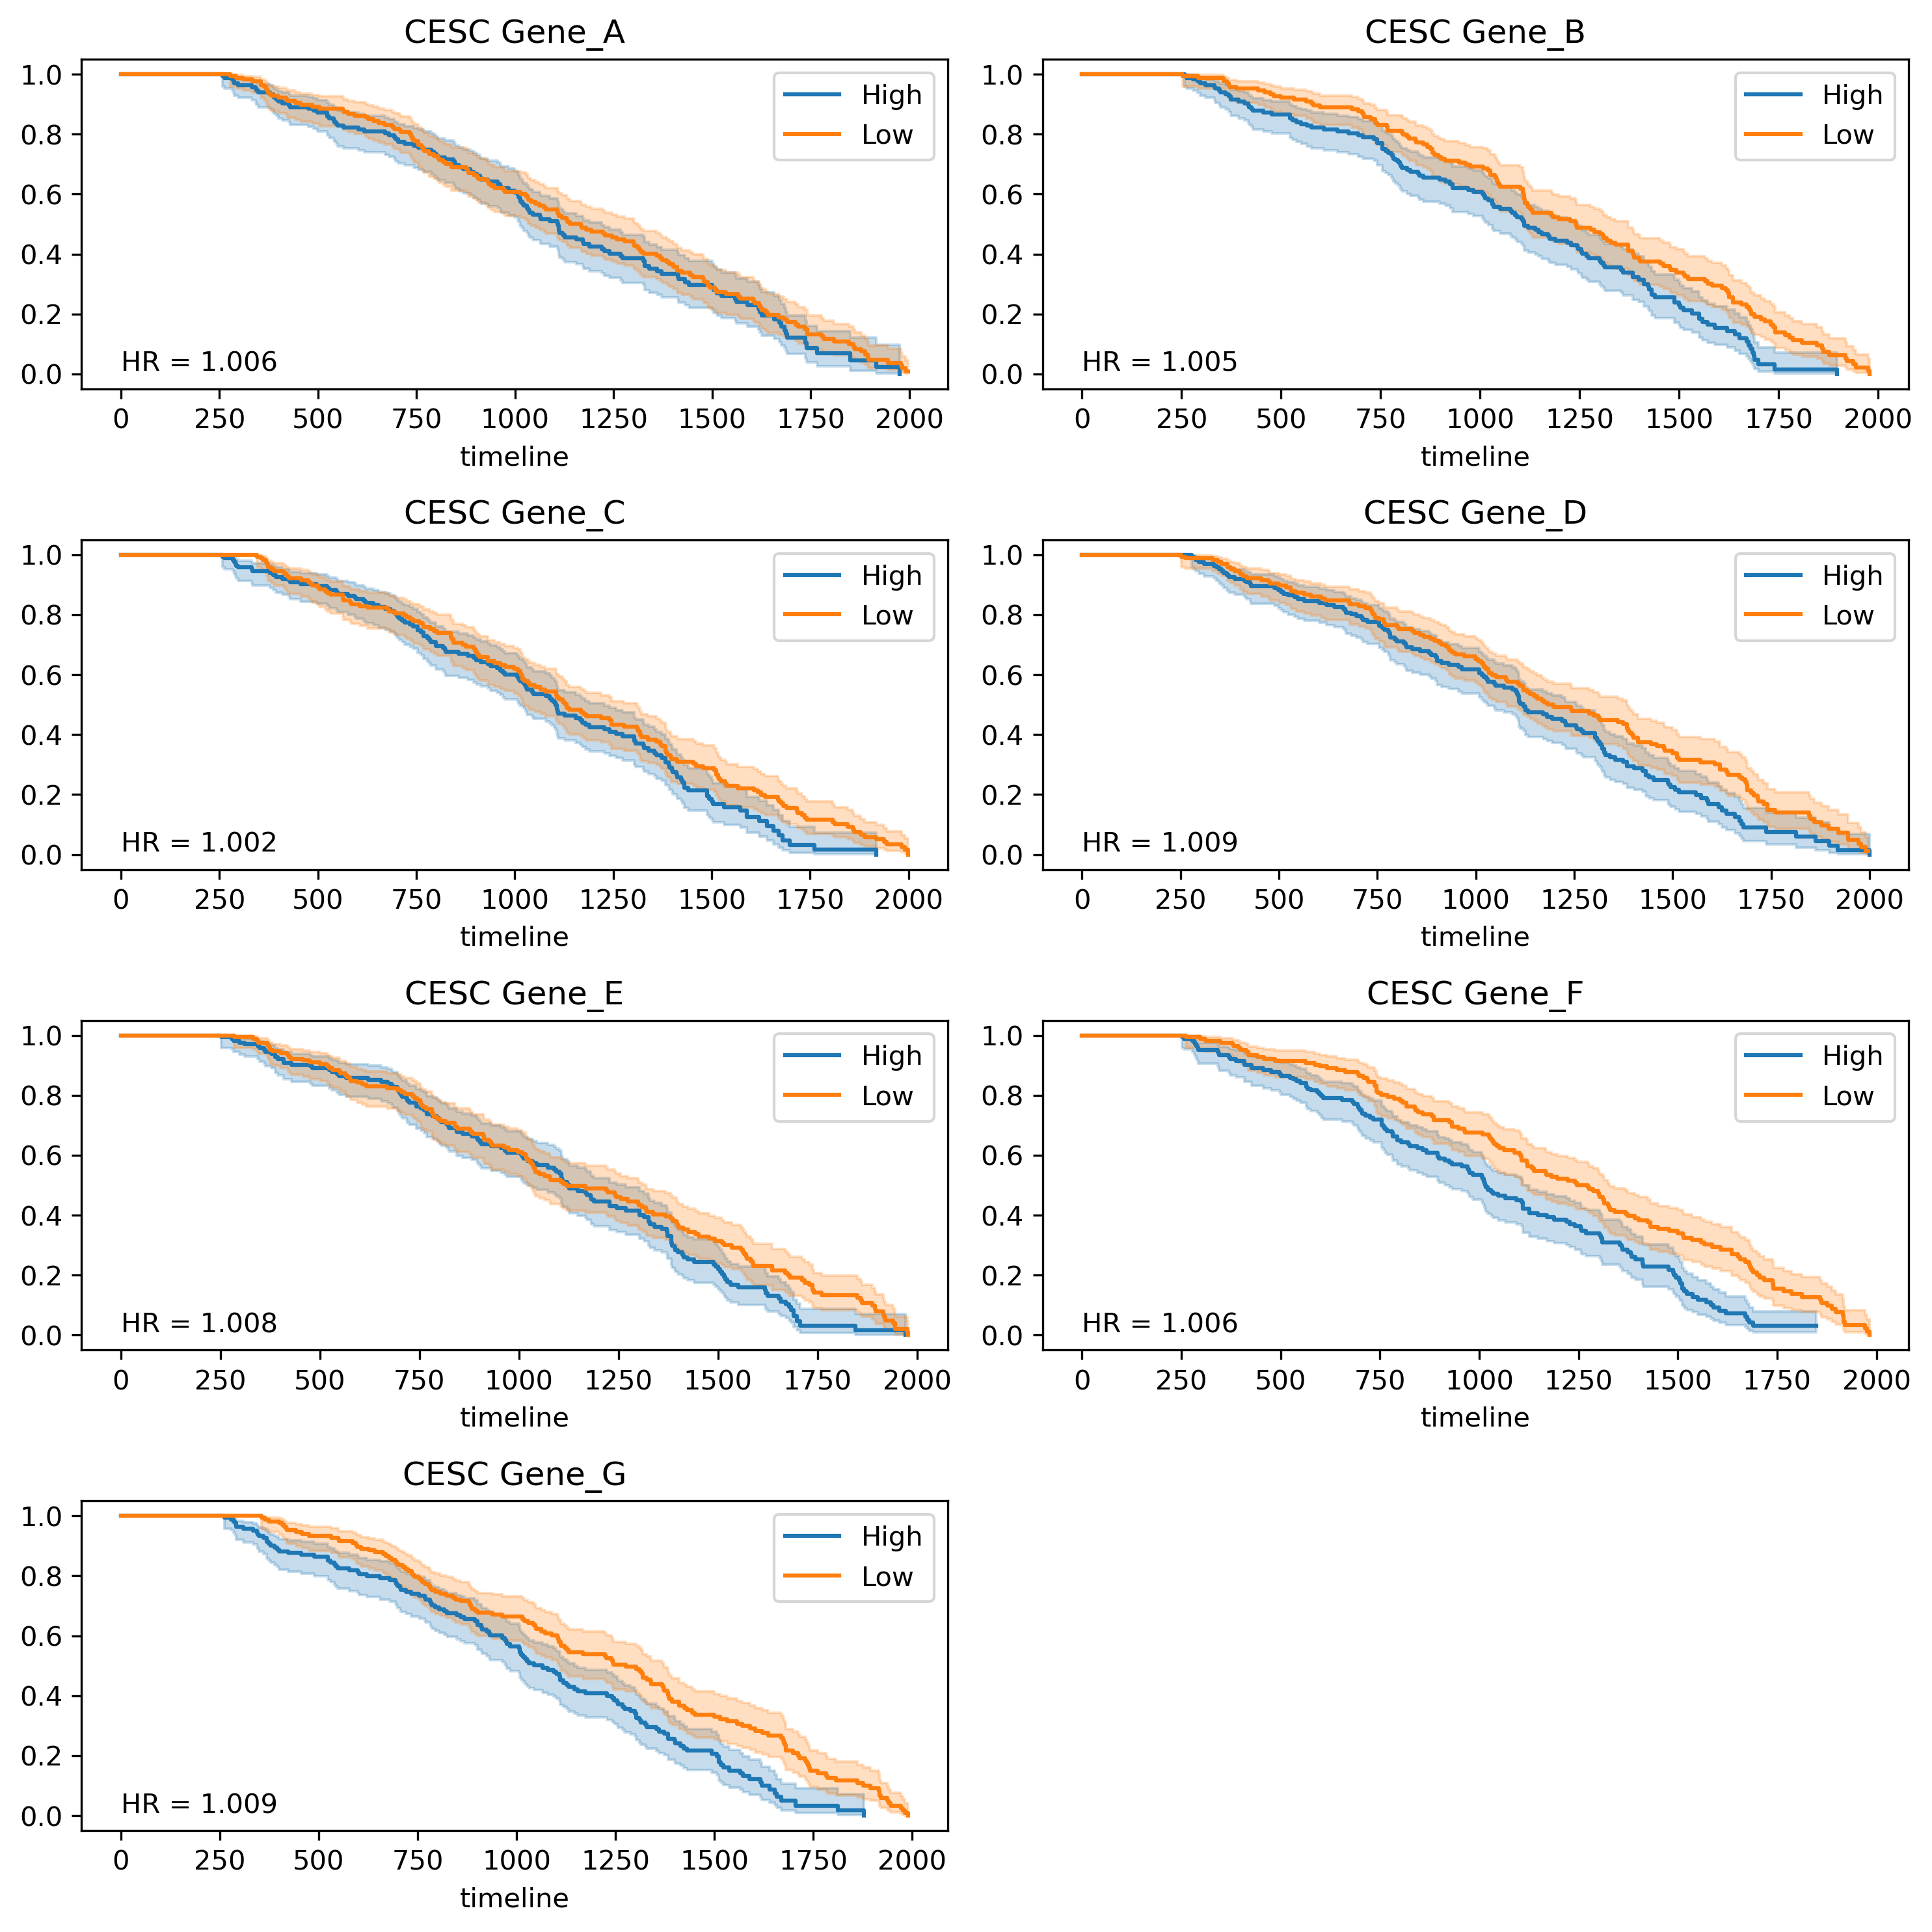

In [16]:
df007 = pd.DataFrame(columns = ["CancerType", "GeneID", "exp(coef)",
                                "lower_95", "upper_95", "p_value"])
count_i = 1
for i in cancerlist:
    df  = alldata.loc[alldata['CancerType'] == i]
    alldata0 = alldata[[*genes]]
    plt.subplots(figsize=(25, 80), dpi=150, subplot_kw={'aspect': 'equal'})
    data = pd.DataFrame()
    count_j = 1
    for j in genes:
        plt.subplot(4, 2, count_j)
        data = df[[j]].copy()
        data0 = pd.merge(data, clinical_data, left_index=True, right_index=True)
        data0['quantile'] = pd.qcut(df[j], 3, labels=False, duplicates="drop")
        data0.drop(['SampleID'], axis = 1, inplace = True)
        cph.fit(df=data0, duration_col='T', event_col='E')
        exp_coef = round(cph.summary.loc[j, 'exp(coef)'],3)
        lower95  = round(cph.summary.loc[j, 'exp(coef) lower 95%'],3)
        upper95  = round(cph.summary.loc[j, 'exp(coef) upper 95%'],3)
        p_value  = '{:0.3e}'.format(cph.summary.loc[j, 'p'])
        #print(i,"\t", j,"\t",exp_coef,"\t", lower95, "\t", upper95,"\t", p_value)
        to_append = [[i, j, exp_coef, lower95, upper95, p_value]]
        df007 = df007.append(pd.DataFrame(to_append,
                                      columns = ["CancerType", "GeneID", "exp(coef)",
                                                 "lower_95", "upper_95", "p_value"]), ignore_index = True)
        plt.text(0.0, 0.01, "HR = " + str(exp_coef), fontsize = 10)
        data_high =  data0.loc[data0['quantile'] == 2]
        T = data_high['T']; E = data_high['E']
        kmf.fit(T, E, label = "High")
        ax = kmf.plot_survival_function(figsize = (10, 10))
        data_low  =  data0.loc[data0['quantile'] == 0]
        T = data_low['T']; E = data_low['E']
        kmf.fit(T, E, label= "Low")
        ax = kmf.plot_survival_function()
        ax.set_title(i  + " " + j)
        count_j += 1
        plt.tight_layout()
        count_i += 1    
    #plt.show()
#plt.savefig('foo.png')
#plt.savefig("./plots/" + str(i) + '_foo.png')
#plt.show()

In [17]:
print(df007)

   CancerType  GeneID  exp(coef)  lower_95  upper_95    p_value
0         ACC  Gene_A      0.927     0.887     0.968  6.708e-04
1         ACC  Gene_B      0.924     0.882     0.968  8.993e-04
2         ACC  Gene_C      0.937     0.896     0.980  4.244e-03
3         ACC  Gene_D      0.937     0.894     0.981  5.154e-03
4         ACC  Gene_E      0.989     0.947     1.033  6.176e-01
5         ACC  Gene_F      0.937     0.896     0.979  3.434e-03
6         ACC  Gene_G      0.996     0.983     1.009  5.307e-01
7        BLCA  Gene_A      0.918     0.853     0.987  2.071e-02
8        BLCA  Gene_B      0.919     0.857     0.986  1.849e-02
9        BLCA  Gene_C      0.948     0.885     1.015  1.253e-01
10       BLCA  Gene_D      0.973     0.907     1.043  4.387e-01
11       BLCA  Gene_E      0.913     0.851     0.980  1.163e-02
12       BLCA  Gene_F      0.940     0.879     1.005  7.092e-02
13       BLCA  Gene_G      0.959     0.903     1.018  1.661e-01
14        LGG  Gene_A      0.997     0.9

In [18]:
    chp_summary = chp_summary.append(pd.DataFrame(chp_summary, columns = [
            "CancerType", "GeneID", "exp(coef)", "lower_95",
            "upper_95", "p_value"]), ignore_index=True)

NameError: name 'chp_summary' is not defined